In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytictoc

import warnings
warnings.filterwarnings('ignore')

import watershed

## Chạy trên video

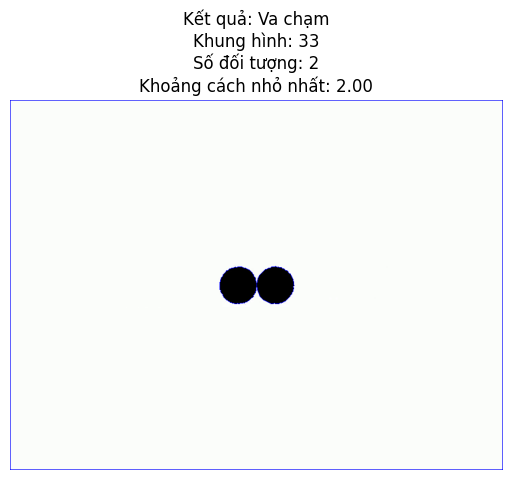

Elapsed time is 3.533953 seconds.


In [5]:
video_path = 'Resource/video2.mp4'

time = pytictoc.TicToc()
time.tic()
watershed.check_collision_watershed_video(video_path)
time.toc()